# Intrinsic Gaussian CAR model
CARモデルのPyMC3実装を参考にして, Intrinsic Gaussian CARモデルを実装する.   
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

参考文献:
Exact sparse CAR models in Stan. Max Joseph. August 20, 2016  
https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html

de oliveira, Victor. (2012). Bayesian analysis of conditional autoregressive models. Annals of the Institute of Statistical Mathematics. 64. 107-133. 10.1007/s10463-010-0298-1.   
https://www.ism.ac.jp/editsec/aism/pdf/10463_2010_Article_298.pdf

Intrinsic Gaussian CAR model:
\begin{align}
y_i \mid \{y_j : j \neq i\} \sim \text{Normal}(\alpha\Sigma_{j\neq i} b_{ij}y_j, \tau_i^{-1}).
\end{align}
ここで, $y_i$ は観測データ, $B=(b_{ij})$ は scaled adjacency matrix.
$m_i=i$の近傍場所数とし、$D=(\text{diag}(m_i)), \ W=(w_{ij})$ を $w_{ii}=0$, $i$ と $j$が隣接していたら $w_{ij}=1$, 隣接していなければ $w_{ij}=0$を満たすような adjacency matrix とすると, $B=D^{-1}W$ である.

同時分布は
\begin{align}
y \sim \text{Normal}(0, [\tau (D - \alpha W)]^{-1}).
\end{align}
で与えられる.

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
import ForneyLab.dot2svg
using LinearAlgebra
@everywhere using Mamba
using Plots
using Statistics
using StatsBase

## Lip cancer risk data
まずは同様にScotlandのLip cancer risk dataを準備する. 元データは  
Kemp I. (1989) Scottish Cancer Incidence Atlas 1985. In: Boyle P., Muir C.S., Grundmann E. (eds) Cancer Mapping. Recent Results in Cancer Research, vol 114. Springer, Berlin, Heidelberg

Lip cancer rates $O_i$ は AFF (population employed in agriculture, fishing, or forestry) $a_i$, 場所差パラメーター $\phi_i$, expected rates $E$ を用いて
\begin{align}
O_i &\sim \text{Poisson}(\lambda_i), \\
\log \lambda_i & = \beta_0 + \beta_1 a_i + \phi_i + \log E_i
\end{align}
と表される. 

In [3]:
# observed
observed =
    [ 9, 39, 11, 9, 15,  8, 26,  7,  6, 20, 
     13,  5,  3, 8, 17,  9,  2,  7,  9,  7, 
     16, 31, 11, 7, 19, 15,  7, 10, 16, 11,
      5,  3,  7, 8, 11,  9, 11,  8,  6,  4,
     10,  8,  2, 6, 19,  3,  2,  3, 28,  6,
      1,  1,  1, 1,  0,  0]
# expected rates
expected =
    [ 1.4,  8.7, 3.0,  2.5,  4.3,  2.4,  8.1, 2.3,  2.0,  6.6,
      4.4,  1.8, 1.1,  3.3,  7.8,  4.6,  1.1, 4.2,  5.5,  4.4,
     10.5, 22.7, 8.8,  5.6, 15.5, 12.5,  6.0, 9.0, 14.4, 10.2,
      4.8,  2.9, 7.0,  8.5, 12.3, 10.1, 12.7, 9.4,  7.2,  5.3,
     18.8, 15.8, 4.3, 14.6, 50.7,  8.2,  5.6, 9.3, 88.7, 19.6, 
      3.4,  3.6, 5.7,  7.0,  4.2,  1.8]
#  AFF (population employed in agriculture, fishing, or forestry)
aff = 
   [16, 16, 10, 24, 10, 24, 10, 7,  7, 16,
     7, 16, 10, 24,  7, 16, 10, 7,  7, 10,
     7, 16, 10,  7,  1,  1,  7, 7, 10, 10,
     7, 24, 10,  7,  7,  0, 10, 1, 16,  0,
     1, 16, 16,  0,  1,  7,  1, 1,  0,  1,
     1, 0, 1, 1, 16, 10] ./ 10;
#  Spatial adjacency information
adj = 
    [[5, 9, 11,19],
    [7, 10],
    [6, 12],
    [18,20,28],
    [1, 11,12,13,19],
    [3, 8],
    [2, 10,13,16,17],
    [6],
    [1, 11,17,19,23,29],
    [2, 7, 16,22],
    [1, 5, 9, 12],
    [3, 5, 11],
    [5, 7, 17,19],
    [31,32,35],
    [25,29,50],
    [7, 10,17,21,22,29],
    [7, 9, 13,16,19,29],
    [4, 20, 28,33,55,56],
    [1, 5, 9, 13,17],
    [4, 18,55],
    [16,29,50],
    [10,16],
    [9, 29,34,36,37,39],
    [27,30,31,44,47,48,55,56],
    [15,26,29],
    [25,29,42,43],
    [24,31,32,55],
    [4, 18,33,45],
    [9, 15,16,17,21,23,25,26,34,43,50],
    [24,38,42,44,45,56],
    [14,24,27,32,35,46,47],
    [14,27,31,35],
    [18,28,45,56],
    [23,29,39,40,42,43,51,52,54],
    [14,31,32,37,46],
    [23,37,39,41],
    [23,35,36,41,46],
    [30,42,44,49,51,54],
    [23,34,36,40,41],
    [34,39,41,49,52],
    [36,37,39,40,46,49,53],
    [26,30,34,38,43,51],
    [26,29,34,42],
    [24,30,38,48,49],
    [28,30,33,56],
    [31,35,37,41,47,53],
    [24,31,46,48,49,53],
    [24,44,47,49],
    [38,40,41,44,47,48,52,53,54],
    [15,21,29],
    [34,38,42,54],
    [34,40,49,54],
    [41,46,47,49],
    [34,38,49,51,52],
    [18,20,24,27,56],
    [18,24,30,33,45,55]];

In [4]:
N = length(observed)

56

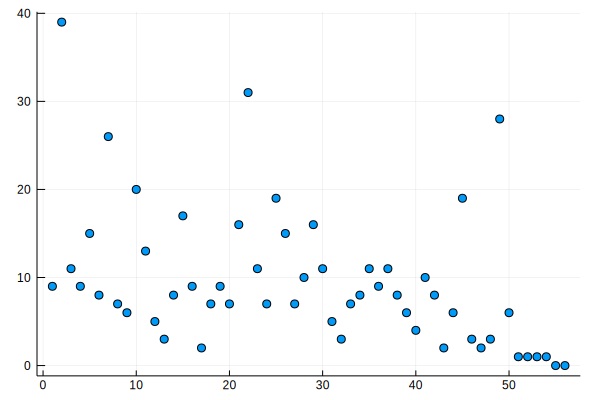

In [5]:
scatter(1:N, observed, label = "")

### 空間統計モデルの定義

In [6]:
car_model = Model(
    beta0 = Stochastic(() -> Normal()),
    beta1 = Stochastic(() -> Normal()),
    
    tau = Stochastic(() -> Distributions.Gamma(2.0, 0.5)),
    alpha = Stochastic(() -> Uniform()),
    phi = Stochastic(1,
        (tau, alpha, N, D, W) -> MvNormalCanon(zeros(N), tau * (D - alpha * W)),
    ),
    
    mu = Logical(1, 
        (beta0, beta1, zscore_aff, phi, log_offset) -> exp.(beta0 .+ beta1 .* zscore_aff .+ phi .+ log_offset)
    ),
    
    y = Stochastic(1,
        (mu, N) -> UnivariateDistribution[Poisson(mu[i]) for i in 1:N],
        false
    )
)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
phi:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStoch

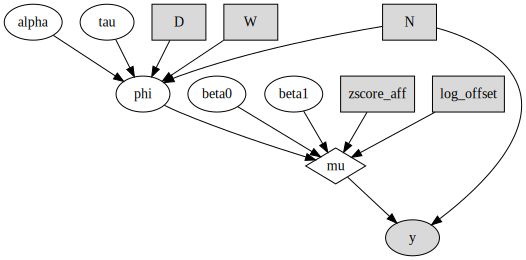

In [7]:
display("image/svg+xml", dot2svg(graph2dot(car_model)))

## データの準備

$D=(\text{diag}(m_i)):$

In [8]:
D = Diagonal(length.(adj))

56×56 Diagonal{Int64,Array{Int64,1}}:
 4  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  6  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  3  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Spatial adjacency informationを行列に展開する

In [9]:
W = zeros(Int64, N, N)
for (i, a) in enumerate(adj)
   W[i, a] .= 1 
end
W

56×56 Array{Int64,2}:
 0  0  0  0  1  0  0  0  1  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  0  0  1  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  1  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0    

In [10]:
log_offset = log.(expected)
zscore_aff = zscore(aff)
car_data = Dict{Symbol, Any}(
    :log_offset => log_offset,
    :zscore_aff => zscore_aff,
    :N => N,
    :D => D,
    :W => W,
    :y => observed
)

Dict{Symbol,Any} with 6 entries:
  :N          => 56
  :y          => [9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1…
  :D          => [4 0 … 0 0; 0 2 … 0 0; … ; 0 0 … 5 0; 0 0 … 0 6]
  :W          => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0]
  :log_offset => [0.336472, 2.16332, 1.09861, 0.916291, 1.45862, 0.875469, 2.09…
  :zscore_aff => [1.07564, 1.07564, 0.196285, 2.24812, 0.196285, 2.24812, 0.196…

初期値の設定

In [11]:
car_inits = [
    Dict{Symbol, Any}(
        :beta0 => 0.0,
        :beta1 => 0.0,
        :tau => 0.5,
        :alpha => 0.5,
        :phi => rand(Normal(), N),
        :mu => observed,
        :y => observed,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[0.606006, 1.30365, -1.21379, -1.55502, 0.155222, 0.316651, 0.804434, 0.560896, 0.563778, 1.3121  …  2.13758, 1.48203, -0.448178, -1.1393, -0.986777, -1.03348, -0.805925, -0.0037207, 0.876839, 0.760336],:tau=>0.5,:beta1=>0.0)      
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[-0.752201, -0.657407, 1.87316, 0.265815, 2.10206, -0.63606, -0.598045, 1.17768, 1.52936, 0.0163315  …  0.39089, -0.0968444, 0.97202, -1.18185, 0.136493, -0.396157, 0.352998, -1.26618, -0.236144, -1.46714],:tau=>0.5,:beta1=>0.0)   
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8

## サンプリング

In [22]:
car_scheme = [
    AMWG([:alpha, :beta0], 1.0), 
    AMWG([:beta1, :phi], 0.1), 
    Slice(:tau, 10.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:alpha, :beta0]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta1, :phi]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│ 

In [23]:
setsamplers!(car_model, car_scheme)
car_sim = mcmc(car_model, car_data, car_inits, 25000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [6:01:59 of 6:02:08 remaining]
      From worker 3:	Chain 2:   0% [6:14:46 of 6:14:55 remaining]
      From worker 4:	Chain 3:   0% [6:23:16 of 6:23:26 remaining]
      From worker 2:	Chain 1:  10% [0:03:42 of 0:04:07 remaining]
      From worker 3:	Chain 2:  10% [0:03:40 of 0:04:05 remaining]
      From worker 4:	Chain 3:  10% [0:03:37 of 0:04:01 remaining]
      From worker 2:	Chain 1:  20% [0:02:29 of 0:03:07 remaining]
      From worker 3:	Chain 2:  20% [0:02:29 of 0:03:06 remaining]
      From worker 4:	Chain 3:  20% [0:02:27 of 0:03:04 remaining]
      From worker 2:	Chain 1:  30% [0:01:58 of 0:02:48 remaining]
      From worker 3:	Chain 2:  30% [0:01:57 of 0:02:48 remaining]
      From worker 4:	Chain 3:  30% [0:01:57 of 0:02:47 remaining]
      From worker 2:	Chain 1:  40% [0:01:35 of 0:02:38 remaining]
      From worker 3:	Chain 2:  40% [0:01:34 of 0:02:37 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.347081 1.31148 … 2.80475 1.03325; 0.376185 2.52761 … 4.15786 1.34993; … ; 0.326859 1.56311 … 2.24219 1.24038; 0.298228 1.27048 … 5.50895 1.37051]

[0.294576 1.74737 … 3.61981 1.87237; 0.262292 3.01095 … 2.76843 1.6105; … ; 0.193369 1.58291 … 1.7874 0.926281; 0.291096 1.48171 … 4.297 0.947131]

[0.195884 1.28859 … 3.81004 1.24222; 0.174995 1.1303 … 5.44008 1.0493; … ; 0.208788 1.97781 … 2.98817 1.35543; 0.211498 1.13618 … 2.8841 1.30511]

## サンプリング結果を確認する

In [24]:
describe(car_sim)

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
             Mean          SD        Naive SE       MCSE         ESS   
  beta1  0.2476342256 0.093189742 0.00120307440 0.0027124876 1180.32256
    tau  1.4571451648 0.441805825 0.00570368867 0.0091039012 2000.00000
  beta0  0.0832228104 0.256686840 0.00331381286 0.0249904237  105.50182
  alpha  0.9495089191 0.053884674 0.00069564815 0.0016750823 1034.80431
 phi[1]  1.1864261777 0.391268953 0.00505126046 0.0251708201  241.63289
 phi[2]  1.1149252909 0.311973120 0.00402755566 0.0249101845  156.84853
 phi[3]  1.0318224992 0.379751472 0.00490257043 0.0249118457  232.37378
 phi[4]  0.4192090111 0.421766394 0.00544498074 0.0253345695  277.15128
 phi[5]  0.9943807922 0.334921669 0.00432382015 0.0244284149  187.97319
 phi[6]  0.6227508784 0.422681850 0.00545679922 0.0249452884  287.11121
 phi[7]  0.9350038529 0.316515241 0.00408619420 0.0252091272  157.64262
 phi[8]  0.954937

phi[20] -0.683929479 -0.105687222  0.1751397903  0.438040037  0.945233471
phi[21] -0.419908871  0.042555944  0.2878531191  0.514861812  0.922041710
phi[22] -0.615487975 -0.211000397 -0.0074169498  0.208584115  0.608607027
phi[23] -0.708666271 -0.211449842  0.0191798107  0.244307387  0.644439819
phi[24] -0.984894630 -0.460857035 -0.2174417798  0.022316139  0.488146800
phi[25] -0.369395120  0.127517700  0.3595521901  0.586697293  1.010902479
phi[26] -0.549575848 -0.039163615  0.2050255778  0.441512308  0.868610746
phi[27] -0.966334281 -0.383106829 -0.0994311702  0.178943780  0.668131480
phi[28] -0.777046190 -0.248111623  0.0122789393  0.250224350  0.671124317
phi[29] -0.600371153 -0.148379972  0.0517669583  0.249802980  0.632719413
phi[30] -0.996949973 -0.483746362 -0.2421587177 -0.020329870  0.417034017
phi[31] -0.990433756 -0.451922735 -0.1868491074  0.058408548  0.500562180
phi[32] -1.207807783 -0.605709728 -0.3219030846 -0.025929401  0.476558700
phi[33] -1.011251486 -0.443537552 -0.1

## Plotting
サンプリングされた値と、分布の表示

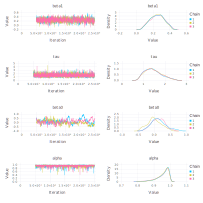

In [25]:
car_p1 = Mamba.plot(car_sim, legend = true);
Mamba.draw(car_p1[:, 1:4], nrow = 4, ncol = 2)

自己相関と、平均の表示

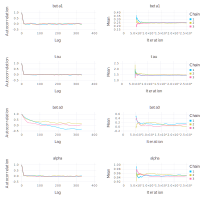

In [26]:
car_p2 = Mamba.plot(car_sim, [:autocor, :mean], legend=true);
Mamba.draw(car_p2[:, 1:4], nrow = 4, ncol = 2)

## 95%信頼区間を求める
シミュレーションされた$\mu$を抽出する

In [27]:
sim_mu = car_sim[:, [:mu], :].value
dim = size(sim_mu)
sim_mu = reshape(sim_mu, dim[1] * dim[3], dim[2])

6000×56 Array{Float64,2}:
  5.47543   7.80311  25.0163   13.7976   …   4.61866  0.840458  2.03772
  6.45924   5.0866   14.8075   25.4208       3.94604  0.840678  1.57088
  5.19031   5.24528  26.3805   19.5094       2.42868  0.344795  2.39158
  7.29583   4.35819  29.4272   16.1894       2.1226   0.899266  1.39038
  6.43344   4.09163  23.6619   18.7056       2.79596  0.855099  1.50474
  9.10009   5.75284  25.7933   14.6984   …   2.28839  1.30046   2.15409
  6.75855   7.06138  26.1954   21.6933       3.56421  2.00654   3.28695
  7.01957   6.32299  32.4716   22.2941       4.27397  1.66969   4.3505 
  4.46417  11.1523   29.4531   14.0479       2.20812  1.43954   1.54349
  5.46685   8.90701  16.7315   15.805        2.49791  0.981212  1.45095
  4.73937  10.871    20.0115   18.3609   …   2.47994  1.99969   3.55453
  7.14147   6.85698  27.1062   18.2375       3.03846  1.03845   2.57818
  5.50171   4.8925   25.2113   19.5791       6.82236  1.44114   3.1394 
  ⋮                                   

各場所が0から100まで値をとる確率を計算する(100超の値をとることもあるが, 確率はかなり小さい)

In [28]:
mu_prob = vcat(map(x -> mean!(ones((1, N)), pdf.(Poisson.(sim_mu), x)), 0:100)...)

101×56 Array{Float64,2}:
 0.00167049   0.00148704   0.0104325    …  0.208138     0.140099   
 0.00768248   0.00715571   0.0353548       0.287789     0.218323   
 0.0190507    0.0185297    0.0650288       0.230026     0.209562   
 0.0339672    0.0344894    0.0865269       0.140508     0.162697   
 0.0489417    0.0519428    0.0937897       0.0732362    0.111706   
 0.0606874    0.0675016    0.0884668    …  0.0344976    0.0702262  
 0.0673339    0.0787872    0.0757341       0.0151862    0.0411335  
 0.0686242    0.0848691    0.060565        0.00637639   0.0227225  
 0.0654512    0.0860267    0.046214        0.00258622   0.0119587  
 0.0592195    0.0832329    0.034247        0.00102153   0.006047   
 0.0513412    0.0776706    0.0251096    …  0.000395184  0.00295678 
 0.042963     0.0704239    0.0186645       0.000150382  0.00140414 
 0.0348859    0.0623493    0.0145371       5.64786e-5   0.000649199
 ⋮                                      ⋱               ⋮          
 5.46403e-8   9.86549e-

強引に和を1にしてしまう

In [29]:
mu_prob = mu_prob ./ mapslices(sum, mu_prob, dims = [1])

101×56 Array{Float64,2}:
 0.00167049   0.00148704   0.0104325    …  0.208138     0.140099   
 0.00768248   0.00715571   0.0353548       0.287789     0.218323   
 0.0190507    0.0185297    0.0650288       0.230026     0.209562   
 0.0339672    0.0344894    0.0865269       0.140508     0.162697   
 0.0489417    0.0519428    0.0937897       0.0732362    0.111706   
 0.0606874    0.0675016    0.0884668    …  0.0344976    0.0702262  
 0.0673339    0.0787872    0.0757341       0.0151862    0.0411335  
 0.0686242    0.0848691    0.060565        0.00637639   0.0227225  
 0.0654512    0.0860267    0.046214        0.00258622   0.0119587  
 0.0592195    0.0832329    0.034247        0.00102153   0.006047   
 0.0513412    0.0776706    0.0251096    …  0.000395184  0.00295678 
 0.042963     0.0704239    0.0186645       0.000150382  0.00140414 
 0.0348859    0.0623493    0.0145371       5.64786e-5   0.000649199
 ⋮                                      ⋱               ⋮          
 5.46403e-8   9.86549e-

quantileを求める

In [30]:
sim_categorical = vec(mapslices(Distributions.Categorical, mu_prob, dims = [1]));
sim_quantile_0025 = quantile.(sim_categorical, 0.025) .- 1
sim_quantile_0500 = quantile.(sim_categorical, 0.500) .- 1
sim_quantile_0975 = quantile.(sim_categorical, 0.975) .- 1

56-element Array{Int64,1}:
 51
 21
 34
 28
 22
 15
 23
 44
 27
 25
 12
 17
 18
  ⋮
 45
 28
 25
 15
 17
 18
 16
 18
 31
 42
  6
  7

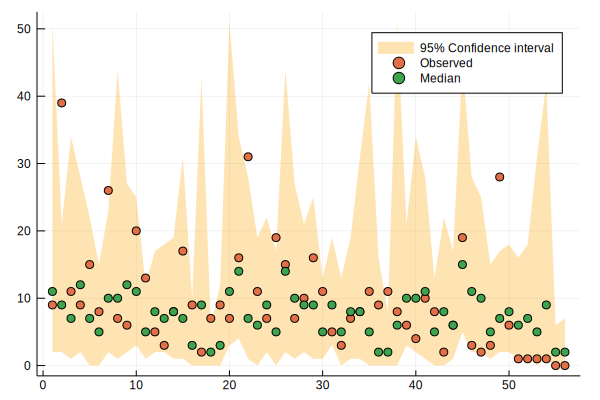

In [31]:
Plots.plot(1:N, sim_quantile_0025, lw = 0, 
    fillrange = sim_quantile_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
scatter!(1:N, observed, label = "Observed")
scatter!(1:N, sim_quantile_0500, label = "Median")